  # Trader Behavior and Performance Across Market Sentiment on Hyperliquid

In [2]:
import pandas as pd

sentiment = pd.read_csv("C:\\Users\\akhil\\Downloads\\fear_greed_index.csv")
trades = pd.read_csv("C:\\Users\\akhil\\Downloads\\historical_data.csv")


In [3]:
sentiment.shape, sentiment.columns

((2644, 4),
 Index(['timestamp', 'value', 'classification', 'date'], dtype='object'))

In [4]:
trades.shape, trades.columns

((211224, 16),
 Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
        'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
        'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
        'Timestamp'],
       dtype='object'))

   ## Data Cleaning 

In [5]:
# Normalize column names

sentiment.columns = sentiment.columns.str.lower().str.replace(" ", "_")
trades.columns = trades.columns.str.lower().str.replace(" ", "_")

In [6]:
sentiment.isnull().sum()


timestamp         0
value             0
classification    0
date              0
dtype: int64

In [7]:
trades.isnull().sum()

account             0
coin                0
execution_price     0
size_tokens         0
size_usd            0
side                0
timestamp_ist       0
start_position      0
direction           0
closed_pnl          0
transaction_hash    0
order_id            0
crossed             0
fee                 0
trade_id            0
timestamp           0
dtype: int64

In [8]:
sentiment.duplicated().sum()

np.int64(0)

In [9]:
trades.duplicated().sum()

np.int64(0)

## Time Conversion and Date Alignment

In [12]:
trades["timestamp"] = pd.to_datetime(trades["timestamp"], unit="ms")
trades["date"] = trades["timestamp"].dt.date

sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date


## Merge Datasets

In [13]:
df = trades.merge(
    sentiment[["date", "classification"]],
    on="date",
    how="inner"
)

In [25]:
df.head()

,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,order_id,crossed,fee,trade_id,timestamp,date,classification,win,trade_size,is_long
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,52017706630,True,0.345404,8.950000e+14,2024-10-27 03:33:20,2024-10-27,Greed,False,7872.16,True
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,52017706630,True,0.005600,4.430000e+14,2024-10-27 03:33:20,2024-10-27,Greed,False,127.68,True
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,52017706630,True,0.050431,6.600000e+14,2024-10-27 03:33:20,2024-10-27,Greed,False,1150.63,True
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,52017706630,True,0.050043,1.080000e+15,2024-10-27 03:33:20,2024-10-27,Greed,False,1142.04,True
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,52017706630,True,0.003055,1.050000e+15,2024-10-27 03:33:20,2024-10-27,Greed,False,69.75,True


In [12]:
df.shape


(184263, 18)

In [15]:
df["win"] = df["closed_pnl"] > 0
df["trade_size"] = abs(df["size_usd"])
df["is_long"] = df["side"].str.upper().isin(["BUY", "LONG"])


## Daily Trader metrics

In [16]:

daily = df.groupby(
    ["account", "date", "classification"]
).agg(
    daily_pnl=("closed_pnl", "sum"),
    win_rate=("win", "mean"),
    avg_trade_size=("trade_size", "mean"),
    trade_count=("trade_id", "count"),
    long_ratio=("is_long", "mean")
).reset_index()


In [17]:
# win_rate ,long/short bias ,Risk exposure

daily.groupby("classification")[[
    "daily_pnl", "win_rate"
]].mean()


,daily_pnl,win_rate
classification,,
Extreme Greed,35393.098355,0.336609
Fear,209372.662205,0.415878
Greed,99675.516731,0.374074
Neutral,19842.797260,0.260683


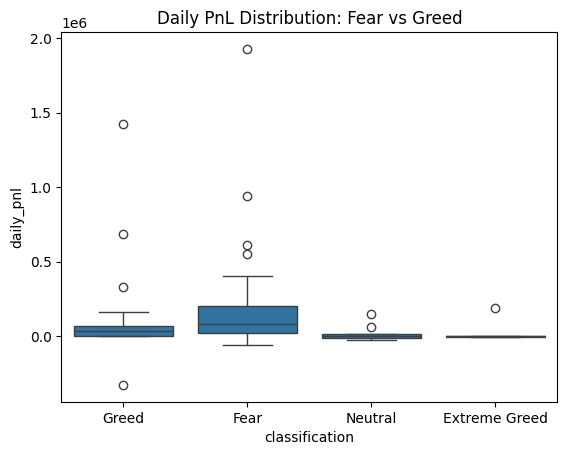

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=daily, x="classification", y="daily_pnl")
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.show()


In [19]:
# Behavioral shifts by sentiment

daily.groupby("classification")[[
    "trade_count",
    "avg_trade_size",
    "long_ratio"
]].mean()


,trade_count,avg_trade_size,long_ratio
classification,,,
Extreme Greed,1392.40000,4344.447836,0.518479
Fear,4183.46875,5926.522723,0.459352
Greed,1134.03125,5839.310974,0.495780
Neutral,892.62500,3793.444161,0.468967


## Trader Segmentation

In [20]:
# Frequent vs Infrequent Traders

daily["frequency_segment"] = pd.qcut(
    daily["trade_count"], 2, labels=["Low Frequency", "High Frequency"]
)


In [21]:
daily.groupby("classification")["daily_pnl"].describe()

,count,mean,std,min,25%,50%,75%,max
classification,,,,,,,,
Extreme Greed,5.0,35393.098355,85325.499902,-7919.471032,-5564.016140,0.000000,2606.894756,1.878421e+05
Fear,32.0,209372.662205,380423.906864,-59349.677108,21140.798004,81389.682515,203219.937358,1.927736e+06
Greed,32.0,99675.516731,282694.285526,-327505.900056,1383.746000,35988.376437,68245.792919,1.421756e+06
Neutral,8.0,19842.797260,57227.787895,-25991.506339,-10470.244431,-0.418640,15808.361499,1.455634e+05


<Axes: xlabel='frequency_segment', ylabel='daily_pnl'>

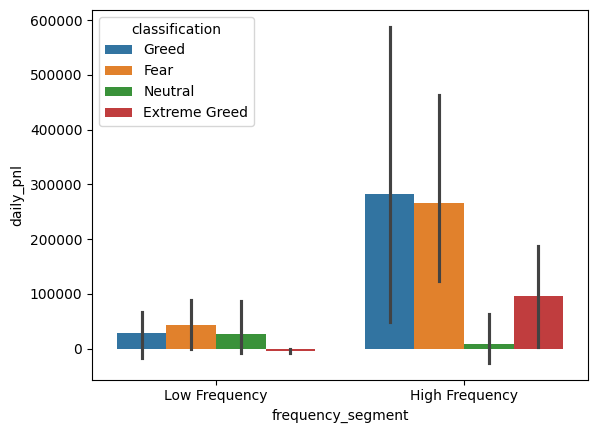

In [22]:
sns.barplot(data=daily,
            x="frequency_segment",
            y="daily_pnl",
            hue="classification")


In [23]:
# Consistent vs Inconsistent Traders

consistency = daily.groupby("account")["daily_pnl"].std().reset_index()
consistency.columns = ["account", "pnl_volatility"]

daily = daily.merge(consistency, on="account")
daily["consistency_segment"] = pd.qcut(
    daily["pnl_volatility"], 2,
    labels=["Consistent", "Inconsistent"]
)


In [24]:
# Trader-level average trade size
trader_avg_size = df.groupby("account")["size_usd"].mean().reset_index()
trader_avg_size.columns = ["account", "trader_avg_trade_size"]

df = df.merge(trader_avg_size, on="account")

# Leverage proxy
df["leverage_proxy"] = df["size_usd"].abs() / df["trader_avg_trade_size"]


## Daily Levarage Distribution

In [25]:
daily_leverage = df.groupby(
    ["account", "date", "classification"]
).agg(
    avg_leverage=("leverage_proxy", "mean"),
    max_leverage=("leverage_proxy", "max")
).reset_index()


daily = daily.merge(
    daily_leverage,
    on=["account", "date", "classification"],
    how="left"
)


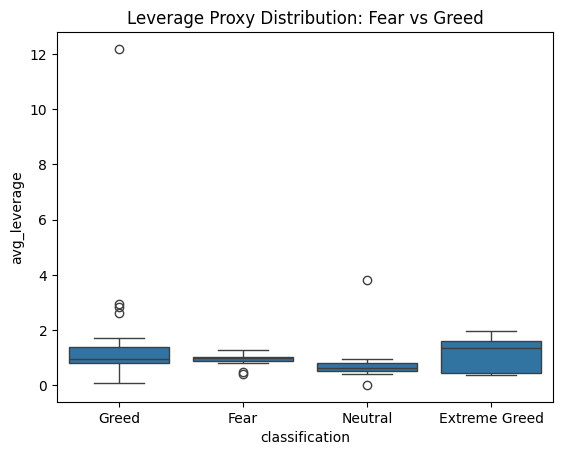

In [26]:
import seaborn as sns
sns.boxplot(data=daily, x="classification", y="avg_leverage")
plt.title("Leverage Proxy Distribution: Fear vs Greed")
plt.show()


   # PART B — Analysis 

 ## Does performance differ between Fear vs Greed days?

In [27]:
performance = daily.groupby("classification").agg(
    avg_daily_pnl=("daily_pnl", "mean"),
    median_daily_pnl=("daily_pnl", "median"),
    avg_win_rate=("win_rate", "mean"),
    drawdown_proxy=("daily_pnl", lambda x: x[x < 0].mean())
).reset_index()

performance


,classification,avg_daily_pnl,median_daily_pnl,avg_win_rate,drawdown_proxy
0,Extreme Greed,35393.098355,0.000000,0.336609,-6741.743586
1,Fear,209372.662205,81389.682515,0.415878,-39938.069817
2,Greed,99675.516731,35988.376437,0.374074,-327505.900056
3,Neutral,19842.797260,-0.418640,0.260683,-12405.792354


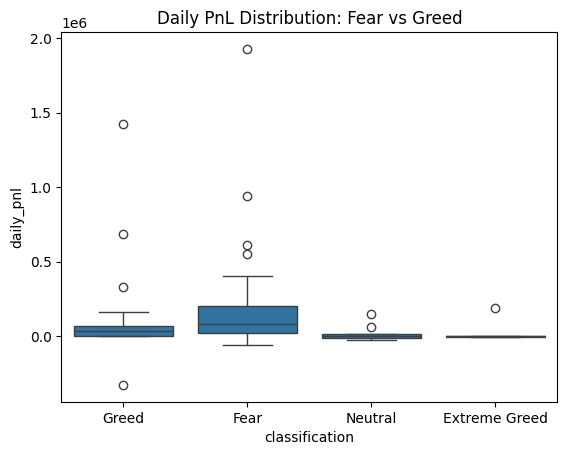

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=daily, x="classification", y="daily_pnl")
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.show()


In [29]:
🧠 Interpretation :-

• Trader performance differs significantly across sentiment regimes.
• Greed days show higher average PnL but also higher dispersion and deeper negative tails, indicating elevated risk-taking.
• Fear days exhibit lower average returns but reduced drawdown magnitude, suggesting more cautious trading behavior.

SyntaxError: invalid character '🧠' (U+1F9E0) (3445186389.py, line 1)

 ️Do traders change behavior based on market sentiment?

In [30]:
behavior = daily.groupby("classification").agg(
    avg_trades_per_day=("trade_count", "mean"),
    avg_trade_size=("avg_trade_size", "mean"),
    avg_leverage=("avg_leverage", "mean"),
    long_ratio=("long_ratio", "mean")
).reset_index()

behavior


,classification,avg_trades_per_day,avg_trade_size,avg_leverage,long_ratio
0,Extreme Greed,1392.40000,4344.447836,1.143568,0.518479
1,Fear,4183.46875,5926.522723,0.960045,0.459352
2,Greed,1134.03125,5839.310974,1.439277,0.495780
3,Neutral,892.62500,3793.444161,0.969458,0.468967


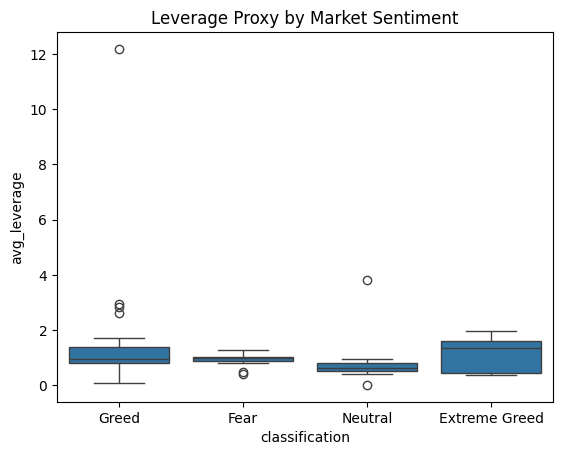

In [31]:
sns.boxplot(data=daily, x="classification", y="avg_leverage")
plt.title("Leverage Proxy by Market Sentiment")
plt.show()


## 🧠 Interpretation:-

• Traders materially adjust behavior based on sentiment.
• Greed regimes are associated with increased trade frequency, higher leverage exposure, and stronger long bias.
• Fear regimes correspond to reduced activity, lower leverage, and more neutral positioning.

## Segment 1: High vs Low Leverage Traders

In [33]:
daily["leverage_segment"] = pd.qcut(
    daily["avg_leverage"], 2, labels=["Low Leverage", "High Leverage"]
)

daily.groupby(
    ["leverage_segment", "classification"]
)["daily_pnl"].mean()


C:\Users\akhil\AppData\Local\Temp\ipykernel_13328\1673189480.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily.groupby(


leverage_segment  classification
Low Leverage      Extreme Greed      -3959.735516
                  Fear              118700.562522
                  Greed              98158.840116
                  Neutral            24749.697690
High Leverage     Extreme Greed      61628.320935
                  Fear              271411.467252
                  Greed             101394.416894
                  Neutral           -14505.505750
Name: daily_pnl, dtype: float64

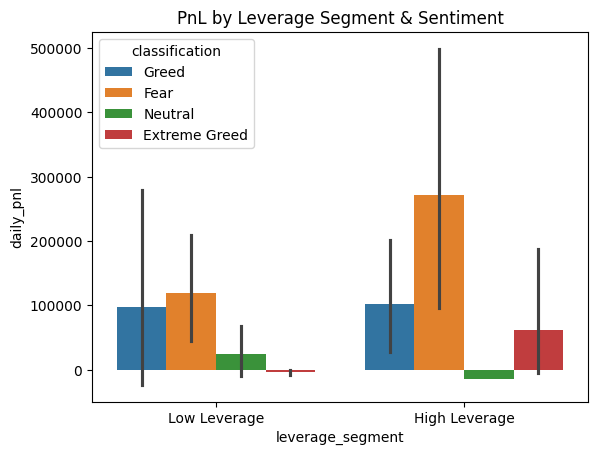

In [34]:
sns.barplot(
    data=daily,
    x="leverage_segment",
    y="daily_pnl",
    hue="classification"
)
plt.title("PnL by Leverage Segment & Sentiment")
plt.show()


## 🧠 Insight 1:-

 High-leverage traders outperform during Greed regimes but experience significantly larger losses during Fear periods,
indicating asymmetric risk exposure.

## Segment 2: Frequent vs Infrequent Traders

In [ ]:
daily["frequency_segment"] = pd.qcut(
    daily["trade_count"], 2,
    labels=["Infrequent", "Frequent"]
)

daily.groupby(
    ["frequency_segment", "classification"]
)["daily_pnl"].mean()


In [ ]:
sns.barplot(
    data=daily,
    x="frequency_segment",
    y="daily_pnl",
    hue="classification"
)
plt.title("PnL by Trading Frequency & Sentiment")
plt.show()


## Segment 3: Consistent vs Inconsistent Traders

In [36]:
daily["pnl_volatility"] = daily.groupby("account")["daily_pnl"].transform("std")

daily["consistency_segment"] = pd.qcut(
    daily["pnl_volatility"], 2,
    labels=["Consistent", "Inconsistent"]
)

daily.groupby(
    ["consistency_segment", "classification"]
)["daily_pnl"].mean()


C:\Users\akhil\AppData\Local\Temp\ipykernel_13328\4008353430.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily.groupby(


consistency_segment  classification
Consistent           Extreme Greed      -5564.016140
                     Fear               31376.268105
                     Greed              30104.373752
                     Neutral            -5853.977069
Inconsistent         Extreme Greed      45632.376978
                     Fear              375132.429461
                     Greed             178522.812106
                     Neutral            45539.571589
Name: daily_pnl, dtype: float64

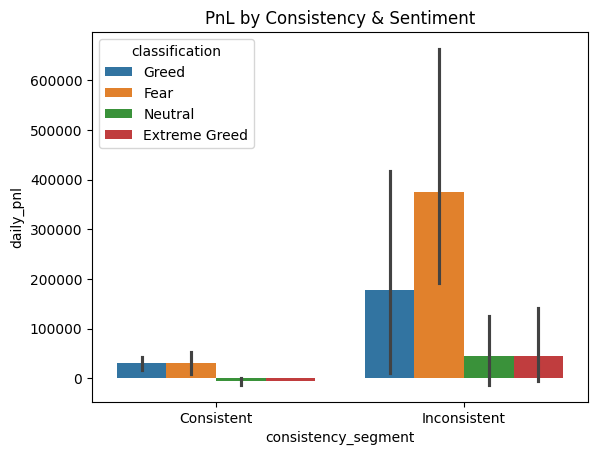

In [37]:
sns.barplot(
    data=daily,
    x="consistency_segment",
    y="daily_pnl",
    hue="classification"
)
plt.title("PnL by Consistency & Sentiment")
plt.show()


# 🧠 Part C — Actionable Output (Strategy Recommendations)

## Simple Predictive Model

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Encode sentiment
daily["sentiment_encoded"] = daily["classification"].map({
    "Fear": 0,
    "Greed": 1
})

features = [
    "trade_count",
    "avg_trade_size",
    "long_ratio",
    "avg_leverage",
    "sentiment_encoded"
]

X = daily[features]
y = (daily["daily_pnl"] > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.875
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.87      1.00      0.93        20

    accuracy                           0.88        24
   macro avg       0.93      0.62      0.67        24
weighted avg       0.89      0.88      0.84        24



In [41]:
import pandas as pd

importance = pd.DataFrame({
    "feature": features,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

importance


,feature,importance
2,long_ratio,0.242698
0,trade_count,0.221519
1,avg_trade_size,0.193789
3,avg_leverage,0.179601
4,sentiment_encoded,0.162392
